## **Netflix Movie Clustering**

In this notebook we try to cluster netflix shows into various categories based on their description. We use K means clustering along with various text encoding techniques to find the the optimum number of separable clusters. 
The main metric used to evaluate a cluster is silhoutte score.

The following steps have been performed



1.   Importing Libraries
2.   Loading the Dataset
3.   Data cleaning and subsetting
4.   Data Visualizations 
5.   Text Preprocessing
6.   Implementing K means clustering using TF-IDF vectorization
7.   Tuning K Value 
8.   Validating results
9.   Implementing K means clustering using Doc2Vec word embedding
10.  Tuning K value
11.  Validaing results
12.  Implementing K means clustering using Auto Encoder word embedding
13.  Tuning K value
14.  Validaing results




### **Importing Libraries **

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import itertools as it
from collections import Counter

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('stopwords')
stop = stopwords.words('english')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering


#tensorflow libraries

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.preprocessing import sequence



# path = '/content/drive/My Drive/glove.6B.200d.txt'
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.text import Tokenizer

# from google.colab import drive
# drive.mount('/content/drive')
# ### Loading Glove vectors

# # if running in local
# glove_dictionary = {}
# #path = 'glove.6B.200d.txt'
# with open(path) as file:
#     for each_line in file:
#         words_in_line, coeff_cients = each_line.split(maxsplit=1)
#         coeff_cients = np.array(coeff_cients.split(),dtype = float)
#         glove_dictionary[words_in_line] = coeff_cients




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **Loading Dataset**

In [ ]:

netflix_titles = pd.read_csv("netflix_titles.csv")
print("Shape of the dataset: ",netflix_titles.shape)
netflix_titles.head()

Shape of the dataset:  (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### **Data Cleaning and Subsetting**

In [ ]:
print("Checking for duplicates \n")
print("Number of unique titles:",netflix_titles['title'].nunique())
print("Number of unique show Id:",netflix_titles['show_id'].nunique())
print("\n")

print("Checking for Nulls \n")
print(netflix_titles.isnull().sum())

#netflix_titles = netflix_titles[['show_id','title','description']]

Checking for duplicates 

Number of unique titles: 8807
Number of unique show Id: 8807


Checking for Nulls 

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


### **Data Visualization**

Text(0, 0.5, 'Ratio')

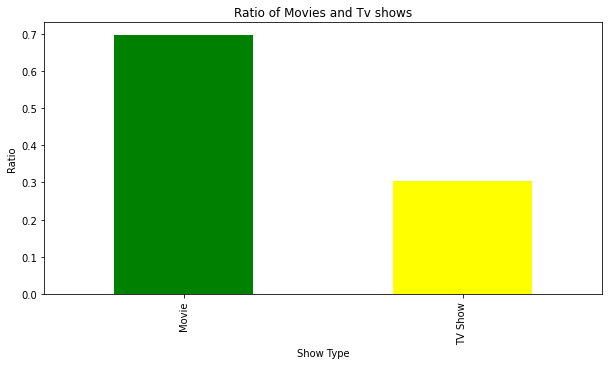

In [ ]:
movie_perc = netflix_titles['type'].value_counts()/netflix_titles.shape[0]
plot1 = movie_perc.plot.bar(color = ['green','yellow'],figsize = (10,5))
plt.title("Ratio of Movies and Tv shows")
plt.xlabel("Show Type")
plt.ylabel("Ratio")


Text(0, 0.5, 'Number of shows')

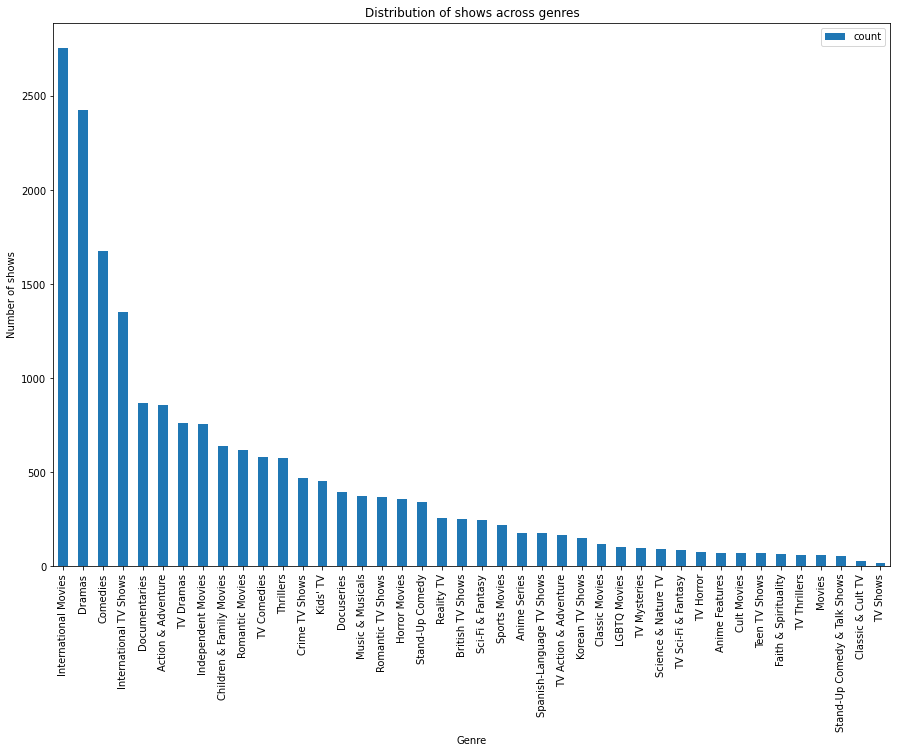

In [ ]:
genres = netflix_titles['listed_in']
genres = [x.split(', ') for x in genres]
genres_count = Counter(it.chain(*map(set, genres)))
genres_df = pd.DataFrame.from_dict(genres_count,orient='index').reset_index()
genres_df.columns = ['genres','count']
genres_df.sort_values(['count'],inplace = True,ascending = False)
genres_df.plot.bar(x = 'genres',y='count',figsize =(15,10) )
plt.title("Distribution of shows across genres")
plt.xlabel("Genre")
plt.ylabel("Number of shows")


### **Text Preprocessing**

In [ ]:
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# From the first assignment
def clean_text(text):
    text = text.lower()
    text = re.sub("'", "", text) 
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'\'s', '', text)
    text = re.sub(r'<br />', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^a-z0-9]"," ", text)
    text = " ".join([x.replace('-', ' ') for x in text.split()])
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)])
    text = " ".join([word for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
netflix_titles['description'] = netflix_titles['description'].apply(clean_text) 
netflix_titles.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,as her father nears the end of his life filmma...
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries",after crossing paths at a party a cape town te...
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",to protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV",feuds flirtations and toilet talk go down amon...
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",in a city of coaching centers known to train i...


In [ ]:
for sent in netflix_titles['description'].iloc[:10]:
  print(sent)
  print('\n')

as her father nears the end of his life filmmaker kirsten johnson stages his death in inventive and comical ways to help them both face the inevitable


after crossing paths at a party a cape town teen sets out to prove whether a private school swimming star is her sister who was abducted at birth


to protect his family from a powerful drug lord skilled thief mehdi and his expert team of robbers are pulled into a violent and deadly turf war


feuds flirtations and toilet talk go down among the incarcerated women at the orleans justice center in new orleans on this gritty reality series


in a city of coaching centers known to train india s finest collegiate minds an earnest but unexceptional student and his friends navigate campus life


the arrival of a charismatic young priest brings glorious miracles ominous mysteries and renewed religious fervor to a dying town desperate to believe


equestrias divided but a bright eyed hero believes earth ponies pegasi and unicorns should be pals

### Implementing K means clustering using TF-IDF vectorizer for feature extraction


In [ ]:
try:
  from sentence_transformers import SentenceTransformer
except:
  !pip install sentence_transformers
  from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
glove_model = SentenceTransformer('sentence-transformers/average_word_embeddings_glove.6B.300d')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.3 MB/s 
     |████████████████████████████████| 5.8 MB 62.1 MB/s 
     |████████████████████████████████| 1.3 MB 45.6 MB/s 
     |████████████████████████████████| 182 kB 60.3 MB/s 
     |████████████████████████████████| 7.6 MB 65.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=6de42709194d43195982cfc916e0466250caea376ad67ad3a5fb6a04945e9482
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/164 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248 [00:00<?, ?B/s]

In [ ]:
data = list(netflix_titles['description'])
bert_embeddings = []
glove_embeddings = []
cnt = 0
for sent in data:
  cnt += 1
  print(cnt)
  embedding = sbert_model.encode(sent)
  bert_embeddings.append(embedding)
  embedding = glove_model.encode(sent)
  glove_embeddings.append(embedding)

Streaming output truncated to the last 5000 lines.
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997

In [ ]:
tsne = TSNE(n_components=2)
print("t-SNE of glove encodings")
tsne_mat_glove = tsne.fit_transform(glove_embeddings)

print("t-SNE of sentenceBert ecodings")
tsne_mat_bert = tsne.fit_transform(bert_embeddings)

t-SNE of glove encodings


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE of sentenceBert ecodings


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


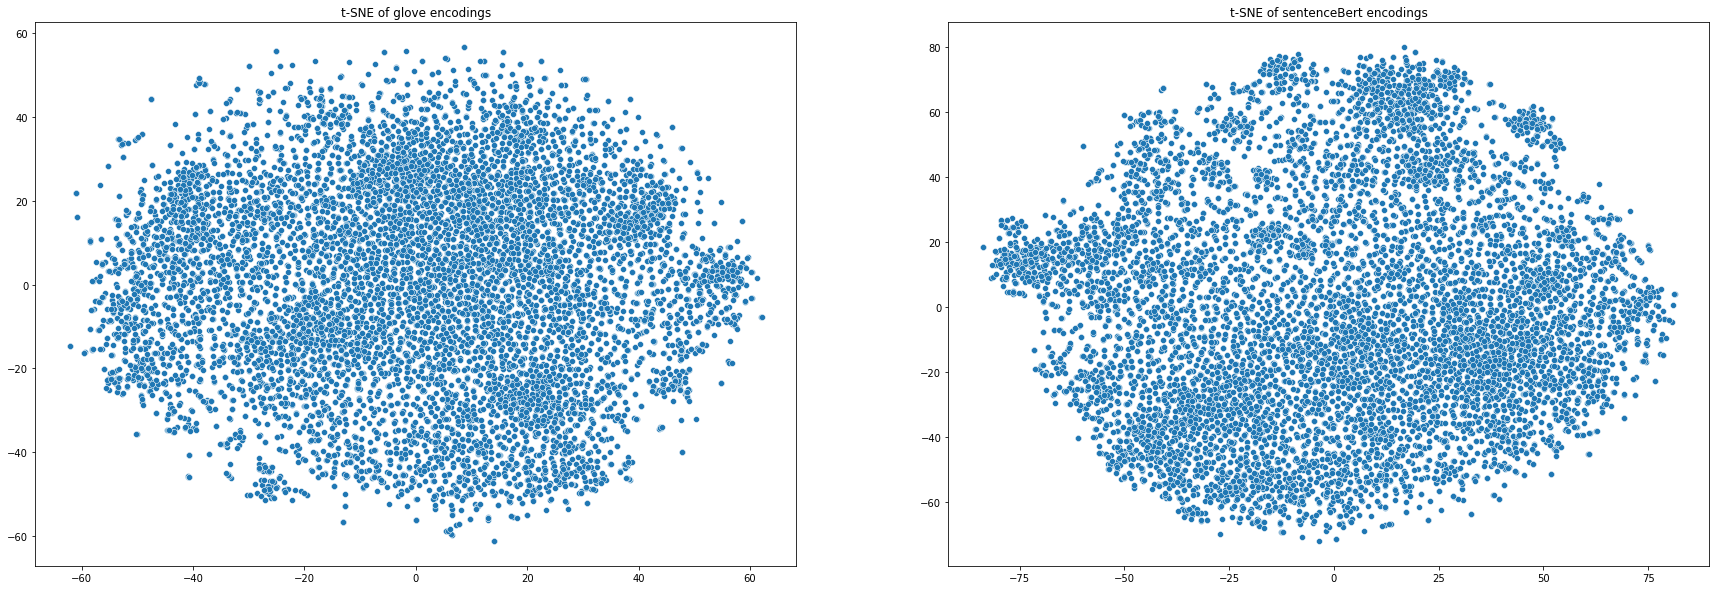

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30,10))
sns.scatterplot(x = tsne_mat_glove[:,0],y = tsne_mat_glove[:,1],ax = axes[0]).set(title='t-SNE of glove encodings')
sns.scatterplot(x = tsne_mat_bert[:,0],y = tsne_mat_bert[:,1],ax = axes[1]).set(title='t-SNE of sentenceBert encodings')
plt.show()

In [ ]:
from google.colab import files

import pickle
with open('sentBert_embeddings_3.pkl', 'wb') as fp:
        pickle.dump(bert_embeddings, fp)

fp.close() 
files.download('sentBert_embeddings_3.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('glove_embeddings.pkl', 'wb') as fp:
        pickle.dump(glove_embeddings, fp)
fp.close() 
files.download('glove_embeddings.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sent = 'As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.'
sent = clean_text(sent)
print(sent)
embedding = sbert_model.encode(sent)
np.sum(embedding)

as her father nears the end of his life filmmaker kirsten johnson stages his death in inventive and comical ways to help them both face the inevitable


-14.816783